In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load training and test data from the files in my google drive
training_data = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/training.csv", header=None, usecols=[19,23], names=['Time','Current'])
test_data = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/test.csv", header=None, usecols=[0, 4], names=['Time','Current'])

In [ ]:
training_data

,Time,Current
0,0.00000,-0.807514
1,0.00005,-0.806968
2,0.00010,-0.806291
3,0.00015,-0.804651
4,0.00020,-0.801798
...,...,...
299996,14.99980,-0.979724
299997,14.99985,-0.954137
299998,14.99990,-0.927560
299999,14.99995,-0.900309


In [ ]:
test_data

,Time,Current
0,0.00000,-0.807514
1,0.00005,-0.806968
2,0.00010,-0.806291
3,0.00015,-0.804651
4,0.00020,-0.801798
...,...,...
119996,5.99980,-0.596946
119997,5.99985,-0.579137
119998,5.99990,-0.556793
119999,5.99995,-0.528649


In [ ]:
# keep rows where time <= 5.4 for training data
# keep rows where time <= 2.4 for test data
training_data = training_data[training_data['Time'] <= 5.4]
test_data = test_data[test_data['Time'] <= 2.4].copy()

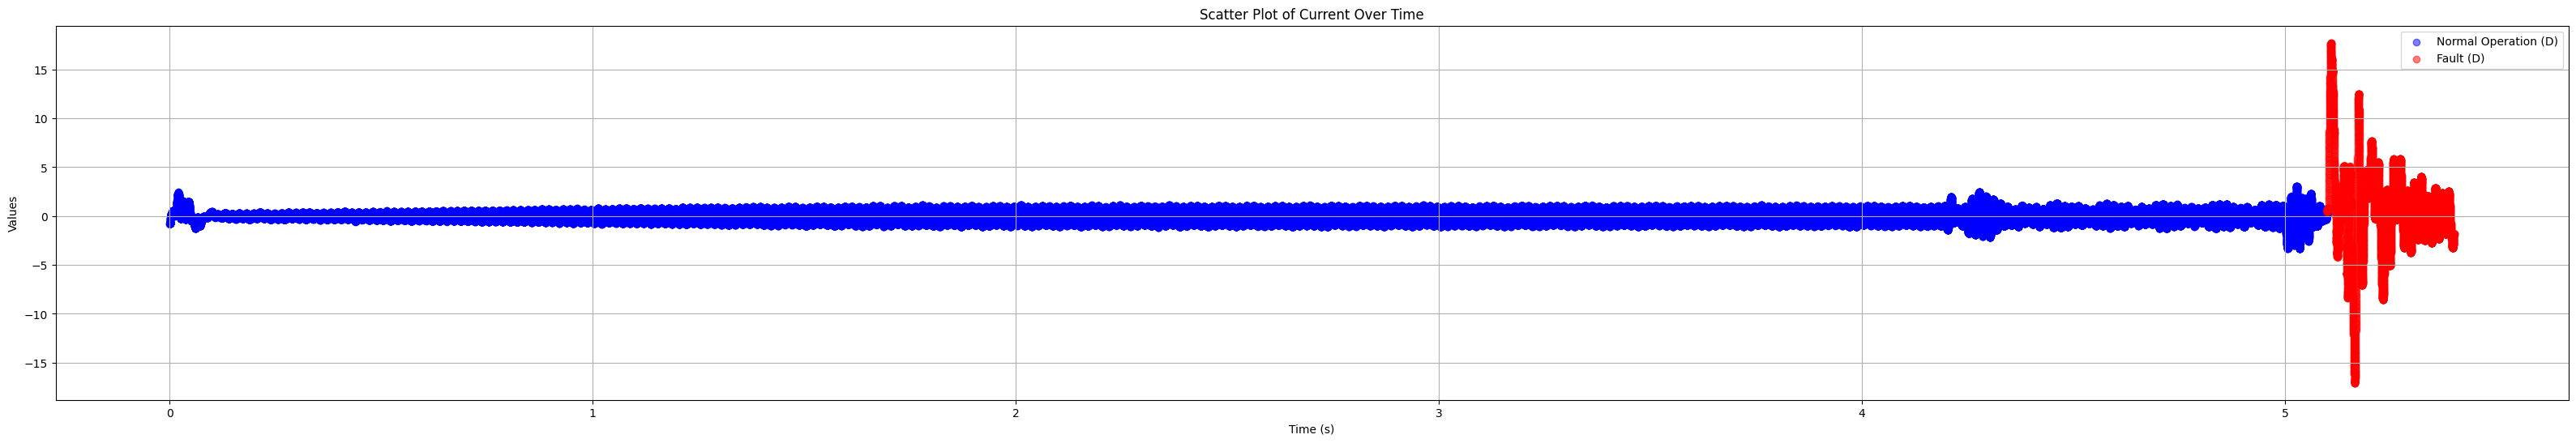

In [ ]:
import matplotlib.pyplot as plt

def clean_df(df):
    # replace infinity values with NaN, Not a Number, the drop missing time or current
    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['Time','Current'])
    # convert strings to numeric
    df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
    df['Current'] = pd.to_numeric(df['Current'], errors='coerce')
    # drop rows that may still have NaN after conversion
    df = df.dropna(subset=['Time','Current'])
    # reset index
    return df.reset_index(drop=True)

# apply cleaning function
training_data = clean_df(training_data)
test_data = clean_df(test_data)

# visualize training data
df = training_data
fault_start = 5.1
fault_end = 5.4
# Separate the data points
fault_data = df[(df['Time'] >= fault_start) & (df['Time'] <= fault_end)]
normal_data = df[(df['Time'] < fault_start) | (df['Time'] > fault_end)]
# create scatter plot for visualization
plt.figure(figsize=(40, 6))

# Plotting for column D
plt.scatter(normal_data['Time'], normal_data['Current'], c='blue', label='Normal Operation (D)', alpha=0.5)
plt.scatter(fault_data['Time'], fault_data['Current'], c='red', label='Fault (D)', alpha=0.5)


plt.title('Scatter Plot of Current Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

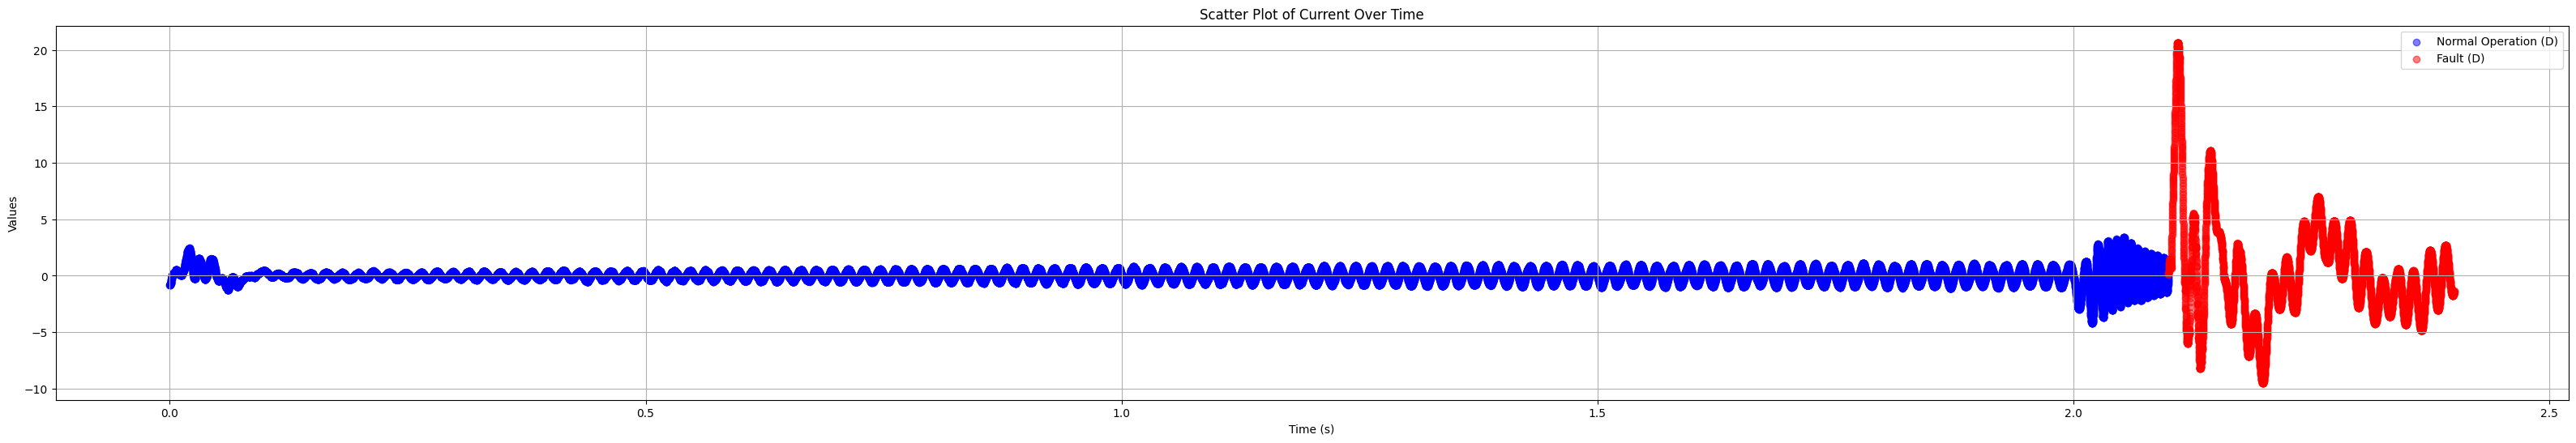

In [ ]:
import matplotlib.pyplot as plt
# visualize test data
df = test_data
fault_start = 2.1
fault_end = 2.4
# Separate the data points
fault_data = df[(df['Time'] >= fault_start) & (df['Time'] <= fault_end)]
normal_data = df[(df['Time'] < fault_start) | (df['Time'] > fault_end)]
# create scatter plot for visualization
plt.figure(figsize=(40, 6))

# Plotting for column D
plt.scatter(normal_data['Time'], normal_data['Current'], c='blue', label='Normal Operation (D)', alpha=0.5)
plt.scatter(fault_data['Time'], fault_data['Current'], c='red', label='Fault (D)', alpha=0.5)


plt.title('Scatter Plot of Current Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Define segmenting and labeling function
# Function divides the data into segments and assigns labels of normal or oscillation
# to each segment based on whether the time overlaps with a known fault period.
def segment_labeling(data, window, overlap, time1, time2):

  # Define the number of data points per segment = window size

  #index determines the start of a window
  #in each step of segmenting loop
  index = 0

  #windolap incorporates overlaping percentage
  windolap = math.floor (window * overlap)

  stride = max(1, window - windolap)

  # Create an empty DataFrame for storing the labels
  labels_df = pd.DataFrame(columns=['label'])

  time_series = []

  # Loop through the data
  while (index + window) < len(data):
      # Extract a segment of data
      segment = data.iloc[index : (index+window)]

      # Labeling based on a given time (the oscillation time is given)
      if any((time1 <= t <= time2) for t in segment['Time']):
        label = 'oscillation'
      else:
        label = 'normal'

      time_series.append(segment['Current'].to_numpy())

      # Append the label to the labels DataFrame
      labels_df = pd.concat([labels_df, pd.DataFrame({'label': [label]})], ignore_index=True)

      #Shifting the index forward by stride = window - windolap
      index += stride

  # return lables_df as a DataFrame
  return time_series, labels_df

In [ ]:
# Apply segmenting function to training data and test data
window = 200
overlap = 0.75

train_X, train_y = segment_labeling(training_data, window, overlap, 5.1, 5.4)
test_X, test_y = segment_labeling(test_data, window, overlap, 2.1, 2.4)

In [ ]:
# display segments of each class
train_y.value_counts()

,count
label,
normal,2037
oscillation,120


In [ ]:
# display segments of each class
test_y.value_counts()

,count
label,
normal,837
oscillation,120


In [ ]:
# convert time series list to numpy arrays for consistency
X_train = np.array(train_X)
X_test = np.array(test_X)

In [ ]:
# print statements
print(X_train.shape)
print(X_test.shape)

(2157, 200)
(957, 200)


Feature matrices:
(2157, 11) (957, 11)
Best C = 1000.0000 with mean F1 (CV) = 0.9118


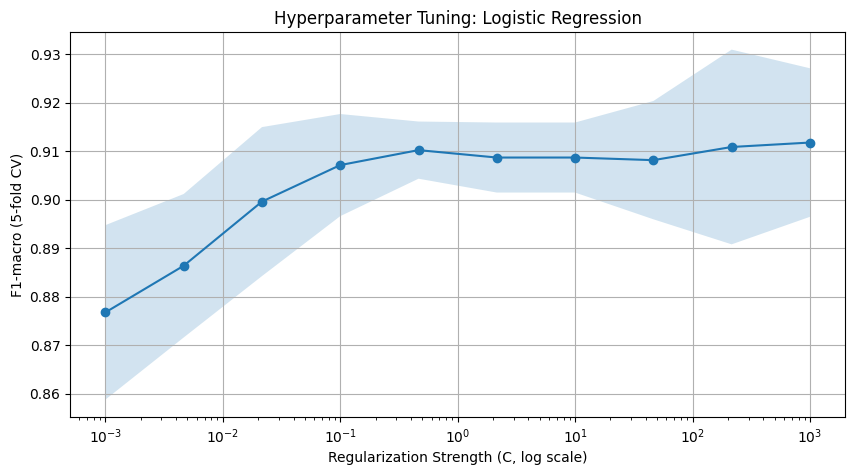

Classification Report (Test):
              precision    recall  f1-score   support

      normal     0.9853    0.9582    0.9715       837
 oscillation     0.7552    0.9000    0.8213       120

    accuracy                         0.9509       957
   macro avg     0.8703    0.9291    0.8964       957
weighted avg     0.9564    0.9509    0.9527       957



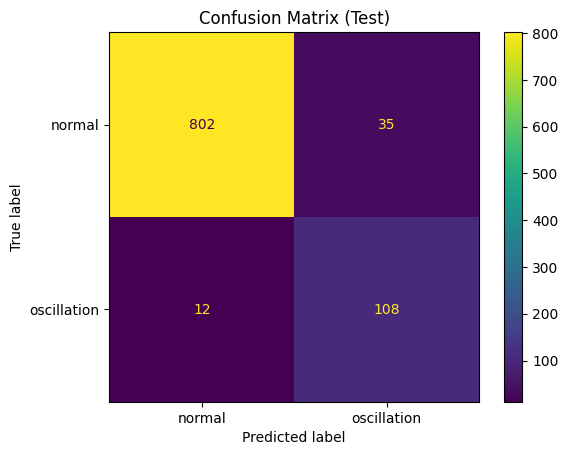

In [ ]:
# Feature extraction functions, computes various statistical features
# for each segment, these features are the shape and behavior of each current waveform.

def rms(x):
    x = np.asarray(x)
    return np.sqrt(np.mean(np.square(x)))

def zero_crossing_rate(x):
    x = np.asarray(x)
    return np.mean(np.abs(np.diff(np.signbit(x))))

def crest_factor(x):
    x = np.asarray(x)
    peak = np.max(np.abs(x))
    r = rms(x)
    return peak / r if r > 0 else 0.0

def energy(x):
    x = np.asarray(x)
    return np.sum(np.square(x))

def spectral_entropy(x, n_bins=32, eps=1e-12):
    x = np.asarray(x)
    fft_mag2 = np.abs(np.fft.rfft(x))**2
    if fft_mag2.sum() == 0:
        return 0.0
    hist, _ = np.histogram(fft_mag2, bins=n_bins, range=(0, np.max(fft_mag2)+eps), density=True)
    p = hist / (hist.sum() + eps)
    return -np.sum(p * np.log2(p + eps))

# Calculate features for each segment
# Returns a dataframe with one row per segment and one column per feature
def extract_features(series_list):
    feats = []
    for x in series_list:
        x = np.asarray(x)
        f = {
            'mean':     np.mean(x),
            'std':      np.std(x, ddof=1) if len(x) > 1 else 0.0,
            'min':      np.min(x),
            'max':      np.max(x),
            'median':   np.median(x),
            'ptp':      np.ptp(x),
            'rms':      rms(x),
            'crest':    crest_factor(x),
            'zcr':      zero_crossing_rate(x),
            'energy':   energy(x),
            'spec_ent': spectral_entropy(x),
        }
        feats.append(f)
    return pd.DataFrame(feats)

# extract features from training and test segments
X_train_df = extract_features(train_X)
X_test_df  = extract_features(test_X)

# Targets
y_train = train_y['label'].values
y_test  = test_y['label'].values

# Standardization rescales features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df)
X_test  = scaler.transform(X_test_df)

print("Feature matrices:")
print(X_train.shape, X_test.shape)

# Logistic Regression model / algorithm with hyperparameter tuning
# The hyperparameter C controls regularization strength
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# define range of c values to test
C_values = np.logspace(-3, 3, 10)
mean_f1, std_f1 = [], []

# Loop through each C value, train and evaluate with some cross validation
for C in C_values:
    lr = LogisticRegression(
        C=C,
        penalty='l2',
        solver='liblinear',
        max_iter=500,
        class_weight='balanced',
        random_state=42
    )
    scores = cross_val_score(lr, X_train, y_train, cv=cv, scoring='f1_macro')
    mean_f1.append(scores.mean())
    std_f1.append(scores.std())

# identify the highest mean f1 score of C
best_idx = int(np.argmax(mean_f1))
best_C = C_values[best_idx]
print(f"Best C = {best_C:.4f} with mean F1 (CV) = {mean_f1[best_idx]:.4f}")

plt.figure(figsize=(10, 5))
plt.semilogx(C_values, mean_f1, marker='o')
plt.fill_between(C_values,
                 np.array(mean_f1) - np.array(std_f1),
                 np.array(mean_f1) + np.array(std_f1),
                 alpha=0.2)
plt.xlabel('Regularization Strength (C, log scale)')
plt.ylabel('F1-macro (5-fold CV)')
plt.title('Hyperparameter Tuning: Logistic Regression')
plt.grid(True)
plt.show()

# Final model training and test evaluation
# Train logistic regression model with best C value
best_lr = LogisticRegression(
    C=best_C,
    penalty='l2',
    solver='liblinear',
    max_iter=500,
    class_weight='balanced',
    random_state=42
)
best_lr.fit(X_train, y_train)

# Make predictions on test data
y_pred = best_lr.predict(X_test)
print("Classification Report (Test):")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=['normal','oscillation'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal','oscillation'])
disp.plot(values_format='d')
plt.title('Confusion Matrix (Test)')
plt.grid(False)
plt.show()